# Mandelbrot

Here we recreate the mandelbrot example to show how to interact with images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hephaistos as hp
from ctypes import *

# dimension of final picture
width = 1920
height = 1080

assert hp.isVulkanAvailable(), "Vulkan is not supported!"
assert hp.isCompilerAvailable(), "No compiler available!"

print(f"Selected Device: {hp.getCurrentDevice().name}")

Selected Device: NVIDIA GeForce RTX 3060 Ti


Let's start with compiling the shader.
You must have [glslang](https://github.com/KhronosGroup/glslang) installed for this to work.
This is also part of the Vulkan SDK.

In [2]:
source = """
#version 460

layout(local_size_x = 4, local_size_y = 4) in;

layout(binding = 0, rgba8) uniform image2D outImage;

layout(push_constant) uniform constants {
    vec2 trans;
    float scale;
} push;

//adapted from "Smooth Iterations" by MisterSirCode
//See: https://www.shadertoy.com/view/sdtcz2

void main() {
    //Get info about this invocation
    ivec2 size = imageSize(outImage);
    ivec2 pos = ivec2(gl_GlobalInvocationID.xy);
    vec2 coord = vec2(pos) + vec2(0.5, 0.5);

    //prepare variables
    vec2 uv = ((2.0 * coord - size) / size.y) * 1.5;
    vec2 z = vec2(0.0);
    float l = 0.0;

    //transform
    uv = uv * push.scale;
    uv += push.trans;

    //main loop
    for (l = 0.0; l < 100.0; l += 1.0) {
        z = vec2(z.x * z.x - z.y * z.y, 2.0 * z.x * z.y) + uv;
        if (dot(z, z) > 65536.0) break;
    }

    //create coloring
    l = l - log2(log2(dot(z,z))) + 4.0;
    vec4 color = vec4(vec3((l > 99.0) ? 0.0 : sin(l / 20.0)) * vec3(0.1, 1.0, 0.8), 1.0);
    
    //store color
    imageStore(outImage, pos, color);
}
"""

code = hp.compileSource(source)
program = hp.Program(code)

Next we only need some allocations and plumping as usual.

In [3]:
class Push(Structure):
    _fields_ = [("transX", c_float), ("transY", c_float), ("scale", c_float)]

buffer = hp.ImageBuffer(width, height)
image = hp.Image(hp.ImageFormat.R8G8B8A8_UNORM, width, height)
program.bindParams(outImage=image)

def render(push: Push):
    hp.beginSequence().And(program.dispatchPush(bytes(push), width // 4, height // 4)).And(hp.retrieveImage(image, buffer)).Submit().wait()
    
    plt.imshow(buffer.numpy())
    plt.show()

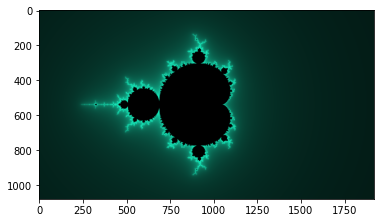

In [4]:
push = Push()
push.transX = 0.0
push.transY = 0.0
push.scale = 1.0

render(push)

You can also save the image if you want to

In [5]:
buffer.save("./mandelbrot.png")